# Lab9: In lab exercise
## st121411

Text(0.5, 1.0, 'Example MNIST sample (category 0)')

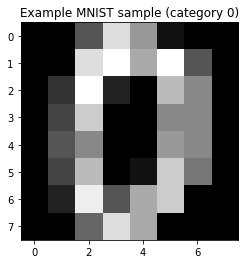

In [2]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# Load data

data = load_digits()

def convert_to_one_hot(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, int(y[i])] = 1
    return y_vect

# Convert target indices to one-hot representation

y_indices = data.target
y = convert_to_one_hot(y_indices)
X = np.matrix(data.data)
M = X.shape[0]
N = X.shape[1]

# Plot an example

plt.imshow(np.reshape(X[0,:],(8,8)), 'gray')
plt.title('Example MNIST sample (category %d)' % y_indices[0])

In [84]:
import random
import warnings
warnings.filterwarnings("ignore")

# Normalize each input feature

def normalize(X):
    M = X.shape[0]
    XX = X - np.tile(np.mean(X,0),[M,1])
    XX = np.divide(XX, np.tile(np.std(XX,0),[M,1]))
    return np.nan_to_num(XX, copy=True,nan=0.0)

XX = normalize(X)

idx = np.arange(0,M)

# Partion data into training and testing dataset

random.shuffle(idx)
percent_train = .6
m_train = int(M * percent_train)
train_idx = idx[0:m_train]
test_idx = idx[m_train:M+1]
X_train = XX[train_idx,:];
X_test = XX[test_idx,:];

y_train = y[train_idx];
y_test = y[test_idx];
y_test_indices = y_indices[test_idx]

# Let's start with a 3-layer network with sigmoid activation functions,
# 6 units in layer 1, and 5 units in layer 2.

h2 = 64
h1 = 30
W = [[], np.random.normal(0,0.1,[N,h1]),
         np.random.normal(0,0.1,[h1,h2]),
         np.random.normal(0,0.1,[h2,10])]
b = [[], np.random.normal(0,0.1,[h1,1]),
         np.random.normal(0,0.1,[h2,1]),
         np.random.normal(0,0.1,[10,1])]
L = len(W)-1

def sigmoid_act(z):
    return 1/(1+np.exp(-z))

def softmax_act(z):
    exps = np.exp(z)
    return exps / np.sum(exps)

def sigmoid_actder(z):
    az = sigmoid_act(z)
    prod = np.multiply(az,1-az)
    return prod

def ff(x,W,b):
    L = len(W)-1
    a = x
    for l in range(1,L+1):
        z = W[l].T*a+b[l]
        if (l == L):
            a = softmax_act(z)
        else:
            a = sigmoid_act(z)
    return a

def loss(y, yhat):
    return - np.dot(y, np.log(yhat))

# Train for 100 epochs with mini-batch size 1

cost_arr = [] 
cost_arr_test = []
W_arr = []
b_arr = []

alpha = 0.01
max_iter = 100
for iter in range(0, max_iter):
    loss_this_iter = 0
    loss_this_iter_test = 0
    order = np.random.permutation(m_train)
    for i in range(0, m_train):
        
        # Grab the pattern order[i]
        
        x_this = X_train[order[i],:].T
        y_this = y_train[order[i],:]

        # Feed forward step
        
        a = [x_this]
        z = [[]]
        delta = [[]]
        dW = [[]]
        db = [[]]
        for l in range(1,L+1):
            z.append(W[l].T*a[l-1]+b[l])
            if (l == L):
                a.append(softmax_act(z[l]))
            else:
                a.append(sigmoid_act(z[l]))
            # Just to give arrays the right shape for the backprop step
            delta.append([]); dW.append([]); db.append([])
            
        loss_this_pattern = loss(y_this, a[L])
        loss_this_iter = loss_this_iter + loss_this_pattern
            
        # Backprop step. Note that derivative of multinomial cross entropy
        # loss is the same as that of binary cross entropy loss. See
        # https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba
        # for a nice derivation.
        
        
        delta[L] = a[L] - np.matrix(y_this).T
        for l in range(L,0,-1):
            db[l] = delta[l].copy()
            dW[l] = a[l-1] * delta[l].T
            if l > 1:
                delta[l-1] = np.multiply(sigmoid_actder(z[l-1]), W[l] *
                             delta[l])
                
        # Check delta calculation
        
        if False:
            print('Target: %f' % y_this)
            print('y_hat: %f' % a[L][0,0])
            print(db)
            y_pred = ff(x_this,W,b)
            diff = 1e-3
            W[1][10,0] = W[1][10,0] + diff
            y_pred_db = ff(x_this,W,b)
            L1 = loss(y_this,y_pred)
            L2 = loss(y_this,y_pred_db)
            db_finite_difference = (L2-L1)/diff
            print('Original out %f, perturbed out %f' %
                 (y_pred[0,0], y_pred_db[0,0]))
            print('Theoretical dW %f, calculated db %f' %
                  (dW[1][10,0], db_finite_difference[0,0]))
        
        for l in range(1,L+1):   
            W[l] = W[l] - alpha * dW[l]
            b[l] = b[l] - alpha * db[l]
            
    for i in range(0, X_test.shape[0]):
        
        # Grab the pattern order[i]
        
        x_this = X_test[i].T
        y_this = y_test[i]

        # Feed forward step
        
        a = [x_this]
        z = [[]]
        delta = [[]]
        dW = [[]]
        db = [[]]
        for l in range(1,L+1):
            z.append(W[l].T*a[l-1]+b[l])
            if (l == L):
                a.append(softmax_act(z[l]))
            else:
                a.append(sigmoid_act(z[l]))
            
        loss_this_pattern_test = loss(y_this, a[L])
        loss_this_iter_test = loss_this_iter_test + loss_this_pattern_test
        
    cost_arr.append(loss_this_iter[0,0])
    cost_arr_test.append(loss_this_iter_test[0,0])
    W_arr.append(W.copy())
    b_arr.append(b.copy())
    print('Epoch %d train loss %f test loss %f' % (iter, loss_this_iter,loss_this_iter_test))

Epoch 0 train loss 2502.944336 test loss 1667.442321
Epoch 1 train loss 2446.888659 test loss 1606.346776
Epoch 2 train loss 2319.509377 test loss 1481.957782
Epoch 3 train loss 2048.136130 test loss 1268.587365
Epoch 4 train loss 1680.968367 test loss 1032.150047
Epoch 5 train loss 1323.154454 test loss 811.199009
Epoch 6 train loss 1037.605557 test loss 669.429468
Epoch 7 train loss 843.540328 test loss 552.240721
Epoch 8 train loss 694.213770 test loss 474.765101
Epoch 9 train loss 579.915023 test loss 394.208894
Epoch 10 train loss 478.830688 test loss 338.825551
Epoch 11 train loss 401.496461 test loss 298.398566
Epoch 12 train loss 338.854246 test loss 262.015593
Epoch 13 train loss 290.454333 test loss 242.213274
Epoch 14 train loss 255.149385 test loss 213.163216
Epoch 15 train loss 225.108368 test loss 196.727740
Epoch 16 train loss 200.015682 test loss 182.354811
Epoch 17 train loss 179.245615 test loss 174.205080
Epoch 18 train loss 163.934595 test loss 161.928855
Epoch 19 t

Lowest Cost: 99.97832071265881 at iter 74


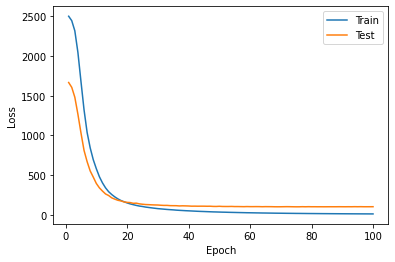

In [85]:
cost_arr_test = np.array(cost_arr_test)
best_cost_idx = np.argmin(cost_arr_test)
print("Lowest Cost:",cost_arr_test[best_cost_idx],"at iter",best_cost_idx)
best_W = W_arr[best_cost_idx]
best_b = b_arr[best_cost_idx]

plt.plot(np.arange(1,max_iter+1,1), cost_arr,label="Train")
plt.plot(np.arange(1,max_iter+1,1), cost_arr_test,label="Test")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Get test set accuracy

def predict_y(W, b, X):
    M = X.shape[0]
    y_pred = np.zeros(M)
    for i in range(X.shape[0]):
        y_pred[i] = np.argmax(ff(X[i,:].T, W, b))
    return y_pred

In [86]:
y_test_predicted = predict_y(best_W, best_b, X_test)
y_correct = y_test_predicted == y_test_indices
test_accuracy = np.sum(y_correct) / len(y_correct)

print('Test accuracy: %.4f' % (test_accuracy))

Test accuracy: 0.9611


By using two hidden layers with 64 and 30 nodes. I was able to achieve an accuracy of ~96% on the test set. Using less nodes resulted in a lower test accuracy and the more nodes i put, better the accuracy seemed to get but it also seems to saturate as I keep increasing the number of nodes. The training error continues to decrease while the test error initially decreases then proceeds to increase with more iterations. This is because the model is trained on training data, therefore the training error continues to decrease with more iterations. But after getting to a point, the model starts to fit the training data more closely and starts to get into the specifics of the training set while becoming less and less general.